## Calculate threshold from undamaged areas


In [4]:
import os
# import rioxarray as rioxr
import xarray as xr
import json
import numpy as np
import matplotlib.pyplot as plt
xr.set_options(keep_attrs=True)

homedir = '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/'

In [5]:
def plot_crevSig(crevSig_da,ax):
    # fig,axs=plt.subplots(1,2,figsize=(15,8))
    crevSig_da.plot.imshow(ax=ax,vmin=0,vmax=0.2,cmap='magma',add_colorbar=False)
    ax.set_title('crevSig')


In [65]:

def calc_threshold(path2files, img_res, n_pix,pct=0.75,plotC=False):
    if isinstance(path2files, list):
        # path2files, imList = path2files
        imList = [os.path.basename(file) for file in path2files]
        path2files = os.path.dirname(path2files[0])
    elif os.path.isdir(path2files):
        # get imgs
        imList= sorted([file for file in os.listdir(path2files) if file.endswith('.nc')])
        # imList = [file for file in imList if str(img_res)+'m' and str(n_pix)+'px' in file]
        imList = [file for file in imList if str(img_res)+'m' in file] 
        imList = [file for file in imList if str(n_pix)+'px'  in file] 
    
        
    # print(imList)
    
    print('SUMMARY: imRes={}, Npix={} ----'.format(img_res, n_pix))
    all_windows = np.array([])
    area_mean = [];
    area_median = [];
    area_pct = [];
    area_pix = [];
    area_max=[];
    count=0
    
    if plotC:
        fig,axs=plt.subplots(1,len(imList),figsize=(15,5))
    for fname in imList:
        da_out = xr.open_dataarray(os.path.join(path2files,fname))
        crevSig = da_out.isel(out=1)
        # print('mean crevSig Area {}: {:.5f}'.format(count,crevSig.values.mean())) 
        all_windows = np.concatenate((all_windows,crevSig.dropna(dim='x').dropna(dim='y').values.flatten()))
        
        area_mean.append(crevSig.mean(skipna=True).values)
        area_median.append(crevSig.median(skipna=True).values)
        area_pct.append( crevSig.quantile(pct, skipna=True).values)
        area_max.append( crevSig.max(skipna=True).values)
        area_pix.append( crevSig.count().values  )
        # print(crevSig.count().values)
        
        # plot
        if plotC:
            plot_crevSig(crevSig,axs[count])
        count+=1
    
    arr_mean = np.array(area_mean)
    arr_median = np.array(area_median)
    arr_pct = np.array(area_pct)
    arr_max = np.array(area_max)
    arr_pix = np.array(area_pix)
    w_mean = np.sum(arr_pix*arr_mean)/np.sum(arr_pix)
    w_pct = np.sum(arr_pix*arr_pct)/np.sum(arr_pix)
    w_median = np.sum(arr_pix*arr_median)/np.sum(arr_pix)
    w_max  = np.sum(arr_pix*arr_max)/np.sum(arr_pix)

    print('      | All pixel | Weighted |  Avg area |')
    print('Mean      {:.3f}      {:.4f}     {:.3f}   '.format( all_windows.mean(),w_mean, np.mean(arr_mean) ) )
    print('Median    {:.3f}      {:.4f}     {:.3f}   '.format( np.median( all_windows),w_mean, np.mean(arr_median) ))
    print('Pct{:.2f}   {:.3f}      {:.4f}     {:.3f}   '.format( pct, np.percentile(all_windows, pct*100), w_pct, np.mean(arr_pct)  ))
    print('Max       {:.3f}      {:.4f}     {:.3f}   '.format( all_windows.max(), w_max, np.mean(arr_max)  ))
    print('-------')
    


## Calculate values
### Threshold Version 0 (2022): mean crevSig value of undamaged areas(all px) 
* RAMP = 0.009 (AIS undamaged areas)
* S1 40:10 = 0.037 (only ASE undamaged areas), 0.036 (AIS undamaged areas)
* S1 40:25 = 0.030 (only ASE undamaged areas), 0.029 (AIS undamaged areas)
* S1 100:10 = 0.027 (only ASE undamaged areas), 0.026 (AIS undamaged areas)

### Threshold Version 1a 1b (2023): pct=0.95 or pct=0.99 crevSig value of undamaged areas (all px)
* RAMP = 0.016  / 0.02 (pct 0.95 / 0.99) (AIS undamaged areas)
* RAMP mamm = 0.023 / 0.029
* S1 40:10 = 0.053 / 0.063  (pct 0.95 / 0.99)
* S1 40:25 = 0.041 / 0.051  (pct 0.95 / 0.99)
* S1 100:10 = 0.038 / 0.046 (pct 0.95 / 0.99)


# Calculations
### 0.95 percentile

---- RAMP ---- 
SUMMARY: imRes=100, Npix=10 ----
      | All pixel | Weighted |  Avg area |
Mean      0.009      0.0094     0.009   
Median    0.009      0.0094     0.009   
Pct0.95   0.016      0.0141     0.014   
Max       0.035      0.0230     0.021   
-------
---- SAR ---- 
SUMMARY: imRes=40, Npix=10 ----
      | All pixel | Weighted |  Avg area |
Mean      0.036      0.0359     0.036   
Median    0.035      0.0359     0.035   
Pct0.95   0.053      0.0521     0.052   
Max       0.089      0.0822     0.080   
-------
SUMMARY: imRes=40, Npix=25 ----
      | All pixel | Weighted |  Avg area |
Mean      0.029      0.0291     0.029   
Median    0.028      0.0291     0.028   
Pct0.95   0.041      0.0397     0.039   
Max       0.088      0.0625     0.057   
-------
SUMMARY: imRes=100, Npix=10 ----
      | All pixel | Weighted |  Avg area |
Mean      0.026      0.0260     0.026   
Median    0.025      0.0260     0.025   
Pct0.95   0.038      0.0371     0.037   
Max       0.085      0.0613 

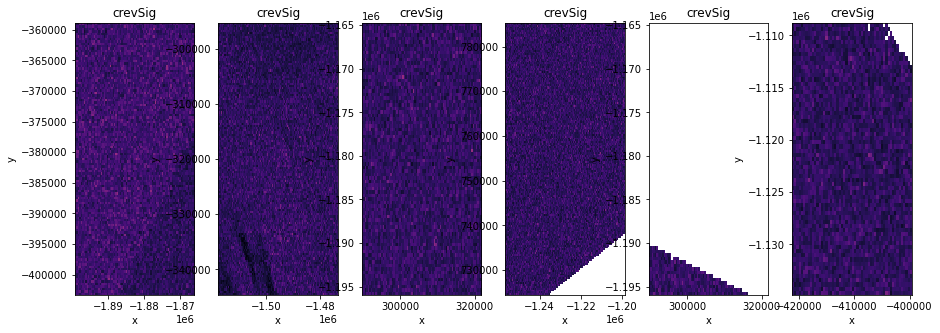

In [95]:
pct = 0.95 

print('---- RAMP AMM ---- ')
imPath = os.path.join(homedir,'Data/RAMP/RAMP_tiled/undamagedAreasAIS/')
outPath = os.path.join(imPath,'damage_detection')
calc_threshold(outPath, img_res=100, n_pix=10,pct=0.95)


print('---- SAR ---- ')
imPath = os.path.join(homedir,'Data/S1_SAR/relorbs/undamagedv0/')
imPath = os.path.join(homedir,'Data/S1_SAR/relorbs/undamaged/')
outPath = os.path.join(imPath,'damage_detection')
# calc_threshold(outPath, img_res=40, n_pix=10,pct=0.90,plotC=True) # all-px : 0.048
# calc_threshold(outPath, img_res=40, n_pix=10,pct=0.99,plotC=True) # all-px : 0.063
calc_threshold(outPath, img_res=40, n_pix=10,pct=0.95,plotC=True) # all-px: 0.053
calc_threshold(outPath, img_res=40, n_pix=25,pct=0.95)
calc_threshold(outPath, img_res=100, n_pix=10,pct=0.95)


In [81]:
import glob

print('---- RAMP mamm ---- ')
imPath = os.path.join(homedir,'Data/RAMP/RAMP_tiled/undamagedAreasAIS/')

outPath = os.path.join(imPath,'damage_detection/')
ncFiles = glob.glob(outPath+'RAMP_mamm*')
ncFiles.sort() 
ncFiles

calc_threshold(ncFiles, img_res=100, n_pix=10,pct=0.95)


---- RAMP mamm ---- 
SUMMARY: imRes=100, Npix=10 ----
      | All pixel | Weighted |  Avg area |
Mean      0.010      0.0104     0.013   
Median    0.008      0.0104     0.012   
Pct0.95   0.023      0.0157     0.019   
Max       0.048      0.0273     0.031   
-------


#### 0.99 percentile

---- RAMP ---- 
SUMMARY: imRes=100, Npix=10 ----
      | All pixel | Weighted |  Avg area |
Mean      0.009      0.0094     0.009   
Median    0.009      0.0094     0.009   
Pct0.99   0.020      0.0173     0.017   
Max       0.035      0.0230     0.021   
-------
---- SAR ---- 
SUMMARY: imRes=40, Npix=10 ----
      | All pixel | Weighted |  Avg area |
Mean      0.036      0.0359     0.036   
Median    0.035      0.0359     0.035   
Pct0.99   0.063      0.0611     0.061   
Max       0.089      0.0822     0.080   
-------
SUMMARY: imRes=40, Npix=25 ----
      | All pixel | Weighted |  Avg area |
Mean      0.029      0.0291     0.029   
Median    0.028      0.0291     0.028   
Pct0.99   0.051      0.0471     0.045   
Max       0.088      0.0625     0.057   
-------
SUMMARY: imRes=100, Npix=10 ----
      | All pixel | Weighted |  Avg area |
Mean      0.026      0.0260     0.026   
Median    0.025      0.0260     0.025   
Pct0.99   0.046      0.0440     0.044   
Max       0.085      0.0613 

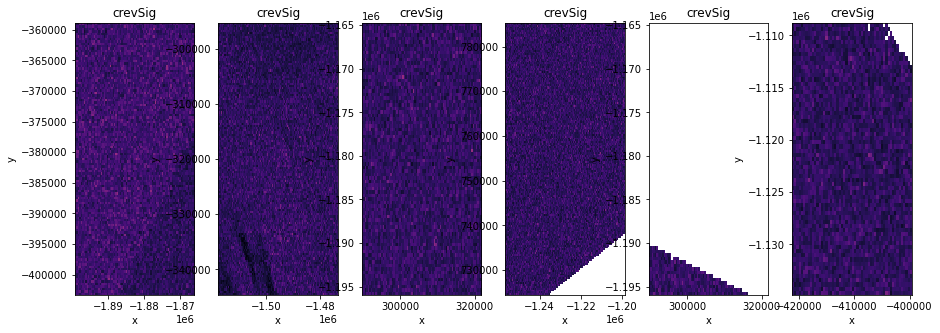

In [105]:
pct=0.99

print('---- RAMP ---- ')
imPath = os.path.join(homedir,'Data/RAMP/RAMP_tiled/undamagedAreasAIS/')
outPath = os.path.join(imPath,'damage_detection')
calc_threshold(outPath, img_res=100, n_pix=10,pct=pct)

print('---- SAR ---- ')
imPath = os.path.join(homedir,'Data/S1_SAR/relorbs/undamagedv0/')
imPath = os.path.join(homedir,'Data/S1_SAR/relorbs/undamaged/')
outPath = os.path.join(imPath,'damage_detection')
# calc_threshold(outPath, img_res=40, n_pix=10,pct=0.90,plotC=True) # all-px : 0.048
# calc_threshold(outPath, img_res=40, n_pix=10,pct=0.99,plotC=True) # all-px : 0.063
calc_threshold(outPath, img_res=40, n_pix=10,pct=pct,plotC=True) # all-px: 0.053
calc_threshold(outPath, img_res=40, n_pix=25,pct=pct)
calc_threshold(outPath, img_res=100, n_pix=10,pct=pct)
